# Pass Clustering

This notebook will look at using clustering to identify different types of passes played by Messi using the Statsbomb open data.

Import the necessary modules.

In [1]:
import sys,os
sys.path.append(os.path.abspath("modules"))
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.cluster as skc

import importing_sb as imsb
import draw_pitch as dp

plt.style.use('football')

%matplotlib inline

Import the data.

In [2]:
data_dir = 'data/open-data/data/'
comp_data = imsb.open_data(data_dir + 'competitions.json')
la_liga_seasons = [i['season_id'] for i in comp_data if i['competition_id'] == 11]
match_data = [sorted(imsb.open_data(data_dir + 'matches/11/{}.json'.format(i)), key = lambda k:k['match_date']) for i in la_liga_seasons]

In [3]:
years = list(range(2018,2003,-1))
seasons = ['18/19','17/18','16/17','15/16','14/15','13/14','12/13','11/12','10/11','09/10','08/09','07/08','06/07','05/06','04/05']
match_id = {}
for i in range(len(years)):
    df = pd.DataFrame(match_data[i])
    match_id[str(years[i])] = df['match_id'].values

In [4]:
event_data = {}
lineup_data = {}
for year in years:
    event_data[str(year)] = []
    lineup_data[str(year)] = []
    for match in match_id[str(year)]:
        event_data[str(year)].append(imsb.open_data(data_dir + 'events/{}.json'.format(str(match))))
        lineup_data[str(year)].append(imsb.open_data(data_dir + 'lineups/{}.json'.format(str(match))))

In [5]:
messi = 'Lionel Andrés Messi Cuccittini'

Firstly, just look at the 18/19 season.

In [6]:
passes_1819 = [imsb.get_pass(match) for match in event_data['2018']]
passes_1819 = pd.concat(passes_1819,ignore_index=True)
passes_1819 = passes_1819[passes_1819['player'] == messi].copy()

Taking only standard passes (no free kicks, corners, throw-ins, etc).

In [7]:
passes_1819 = passes_1819[passes_1819['pass_type'] == 'Standard'].copy()

In [8]:
passes_1819.drop(['event_id','period','minute','second','type','pos_team','team','recipient'],axis=1,inplace=True)

To begin with I will just try a simple feature set of starting and ending locations.

In [9]:
features = ['x','y','end_x','end_y']
kmeans = skc.KMeans()
kmeans.fit(passes_1819[features])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Create a new column which is the cluster to which pass belongs to. We can then look at the number of passes in each cluster.

In [10]:
passes_1819['cluster'] = kmeans.labels_
passes_1819['cluster'].value_counts()

4    312
5    256
6    245
0    238
2    217
7    184
3    180
1    121
Name: cluster, dtype: int64

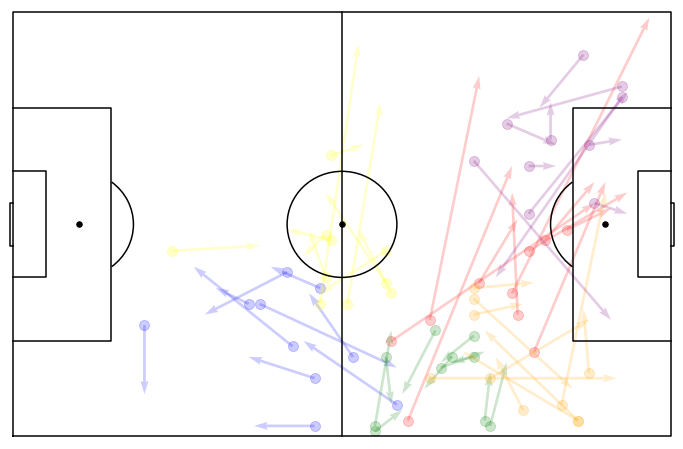

In [11]:
fig,ax = dp.draw_pitch('w','k','h','f')
colours = ['red','blue','green','yellow','orange','purple']
for i in range(6):
    passes_cluster = passes_1819[passes_1819['cluster'] == i].copy()
    passes_cluster = passes_cluster.sample(10)
    ax.scatter(passes_cluster['x'],80-passes_cluster['y'],color=colours[i],alpha=0.2)
    ax.quiver(passes_cluster['x'],80-passes_cluster['y'],passes_cluster['end_x']-passes_cluster['x'],
              (80-passes_cluster['end_y'])-(80-passes_cluster['y']),angles='xy',scale_units='xy',scale=1,
              width=0.004,linewidth=0.5,color=colours[i],alpha=0.2)

## Adding additional features

In addition to the starting and ending locations I will also include the `length`, `angle` as well as the `height` which is described as either `Ground Pass`, `High Pass` or `Low Pass`.

Begin by creating dummy variables for the possible `height` options.

In [12]:
df_dummy_height = pd.get_dummies(passes_1819['height']);
passes_1819 = pd.concat([passes_1819, df_dummy_height], axis=1)

This time I have increased the number of clusters to 20.

In [13]:
features = ['x','y','end_x','end_y','length','angle','Ground Pass','High Pass','Low Pass']
kmeans = skc.KMeans(n_clusters=20)
kmeans.fit(passes_1819[features])
passes_1819['cluster'] = kmeans.labels_

In [14]:
passes_1819['cluster'].value_counts();

Take the five most common clusters for plotting purposes.

In [15]:
common_clus = passes_1819['cluster'].value_counts().index[0:5]

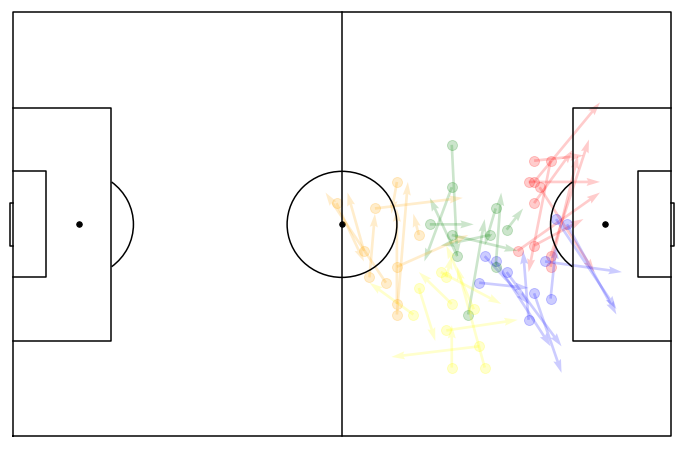

In [16]:
fig,ax = dp.draw_pitch('w','k','h','f')
colours = ['red','blue','green','yellow','orange','purple','cyan','pink','black']
for i in range(len(common_clus)):
    passes_cluster = passes_1819[passes_1819['cluster'] == common_clus[i]].copy()
    passes_cluster = passes_cluster.sample(10)
    ax.scatter(passes_cluster['x'],80-passes_cluster['y'],color=colours[i],alpha=0.2)
    ax.quiver(passes_cluster['x'],80-passes_cluster['y'],passes_cluster['end_x']-passes_cluster['x'],
              (80-passes_cluster['end_y'])-(80-passes_cluster['y']),angles='xy',scale_units='xy',scale=1,
              width=0.004,linewidth=0.5,color=colours[i],alpha=0.2)

## Error dependence on number of clusters

In some applications the number of clusters can be chosen using the "elbow" method. By looking at how the error (inertia) decreases with the number of clusters, the number of clusters can be taken as the point at which the error stops considerably dropping.

However, it is often the case that one will never see this "elbow" structure so it cannot be used. Also, it is often better to just consider the application and use domain knowledge to pick the number of clusters.

Here I show how the inertia drops with cluster number for demonstration, but it does not influence my choice of cluster number.

In [17]:
inertias = []
for i in range(1,21):
    kmeans_test = skc.KMeans(n_clusters=i)
    kmeans_test.fit(passes_1819[features])
    inertias.append(kmeans_test.inertia_)

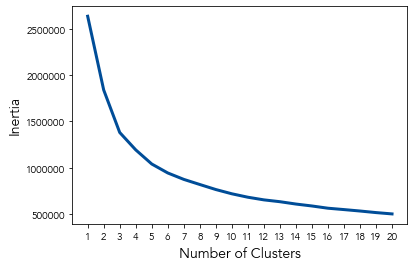

In [18]:
fig,ax = plt.subplots()
ax.plot(np.arange(1,21,1),inertias)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Inertia")
ax.set_xticks(np.arange(1,21,1))
plt.show()

## Success rates in each cluster

In [19]:
passes_1819['outcome'].replace({'Complete': 1,'Incomplete': 0, 'Pass Offside': 0, 'Out': 0, 'Unknown': 0}, inplace=True)

In [20]:
df_success = passes_1819.groupby('cluster').agg(success_rate=("outcome","mean"))

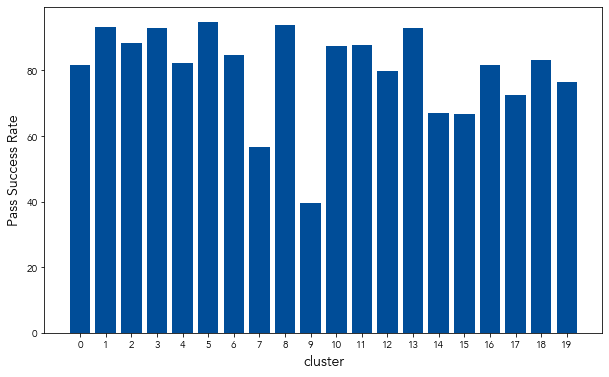

In [21]:
fig,ax = plt.subplots(figsize=(10,6))
ax.bar(np.arange(20),df_success.values.ravel()*100)
ax.set_xticks(np.arange(20))
ax.set_xlabel("cluster")
ax.set_ylabel("Pass Success Rate")
plt.show()

## Using WSL data

In [1]:
import sys,os
sys.path.append(os.path.abspath("modules"))
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.cluster as skc

import importing_sb as imsb
import draw_pitch as dp

plt.style.use('football')

%matplotlib inline

In [2]:
data_dir = 'data/open-data/data/'
comp_data = imsb.open_data(data_dir + 'competitions.json')

comp_id = 37
seasons = [i['season_id'] for i in comp_data if i['competition_id'] == comp_id]
match_data = [sorted(imsb.open_data(data_dir + 'matches/{}/{}.json'.format(comp_id,i)), key = lambda k:k['match_date']) for i in seasons]

match_ids = []
for year in range(len(match_data)):
    match_df = pd.DataFrame(match_data[year])
    match_ids.append(match_df['match_id'].values)

seasons = ['19/20','18/19']
event_data = {}
lineup_data = {}
for i in range(len(seasons)):
    event_data[seasons[i]] = []
    lineup_data[seasons[i]] = []
    for match in match_ids[i]:
        event_data[seasons[i]].append(imsb.open_data(data_dir + 'events/{}.json'.format(str(match))))
        lineup_data[seasons[i]].append(imsb.open_data(data_dir + 'lineups/{}.json'.format(str(match))))

In [34]:
position_list = []
for i in range(len(event_data['18/19'])):
    position_list.append(pd.concat([pd.json_normalize(event_data['18/19'][i][0]['tactics']['lineup'])[['player.name','position.name']],
               pd.json_normalize(event_data['18/19'][i][1]['tactics']['lineup'])[['player.name','position.name']]],
              ignore_index=True))

df_positions = pd.concat(position_list,ignore_index=True).groupby(['player.name','position.name']).size()

positions = []
for i in df_positions.index.get_level_values(0).unique():
    positions.append(df_positions.loc[i].sort_values(ascending=False).index[0])
    
df_pos = pd.DataFrame(data={'pos':positions},index=df_positions.index.get_level_values(0).unique())

In [41]:
df_teams = pd.DataFrame()
for match in lineup_data['18/19']:
    cond1 = [x not in df.index for x in pd.json_normalize(match[0]['lineup'])['player_name'].values]
    cond2 = [x not in df.index for x in pd.json_normalize(match[1]['lineup'])['player_name'].values]
    
    df_team = df.append(pd.DataFrame(data={'team':match[0]['team_name']},index=pd.json_normalize(match[0]['lineup'])[cond1]['player_name'].values))
    df_team = df.append(pd.DataFrame(data={'team':match[1]['team_name']},index=pd.json_normalize(match[1]['lineup'])[cond2]['player_name'].values))

In [42]:
df_players = pd.concat([df_team,df_pos],axis=1)

In [39]:
df_def = df_players[df_players['pos'].str.endswith('Back',na=False)]
df_cdef = df_players[df_players['pos'].str.endswith('Center Back',na=False)]
df_mid = df_players[df_players['pos'].str.endswith('Midfield',na=False)]
df_cmid = df_players[(df_players['pos'].str.endswith('Defensive Midfield',na=False))|
                        (df_players['pos'].str.endswith('Center Midfield',na=False))|
                        (df_players['pos'].str.endswith('Attacking Midfield',na=False))]
df_wing = df_players[(df_players['pos'].str.endswith('Wing Back',na=False))|
                        (df_players['pos'].str.endswith('Right Midfield',na=False))|
                        (df_players['pos'].str.endswith('Left Midfield',na=False))|
                        (df_players['pos'].str.endswith('Wing',na=False))]
df_for = df_players[(df_players['pos'].str.endswith('Wing',na=False))|
                        (df_players['pos'].str.endswith('Forward',na=False))|
                        (df_players['pos'].str.endswith('Striker',na=False))]
df_str = df_players[(df_players['pos'].str.endswith('Forward',na=False))|
                        (df_players['pos'].str.endswith('Striker',na=False))]

Get the pass data.

In [71]:
df = pd.concat([imsb.get_pass(match) for match in event_data['18/19']],ignore_index=True)

Taking only standard passes (no free kicks, corners, throw-ins, etc).

In [72]:
df['y'] = df['y'].transform(lambda x: 80-x)
df['end_y'] = df['end_y'].transform(lambda x: 80-x)
df = df[df['pass_type'] == 'Standard'].copy()
df.drop(['event_id','period','minute','second','type','pos_team','team','recipient'],axis=1,inplace=True)

In [73]:
features = ['x','y','end_x','end_y']
kmeans = skc.KMeans(n_clusters=60)
kmeans.fit(df[features])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=60, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [74]:
df['cluster'] = kmeans.labels_

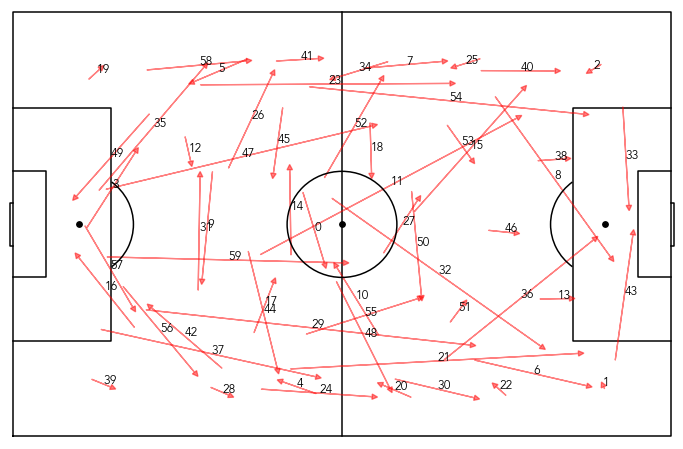

In [75]:
fig,ax = dp.draw_pitch('w','k','h','f')
for i,(x,y,end_x,end_y) in enumerate(kmeans.cluster_centers_):
    ax.arrow(x,y,end_x-x,end_y-y,color='r',head_width=1,head_length=1,alpha=0.5,length_includes_head=True)
    ax.text((end_x+x)/2,(end_y+y)/2,str(i),fontsize=12)
    
plt.show()

### Who plays the dangerous cutbacks into the box?

Looking at the cluster map, clusters 33 and 43 represent these dangerous cutbacks.

In [186]:
def find_success(df,cluster):
    df_cluster = df[df['cluster'] == cluster].groupby('player').count().sort_values('index',ascending=False)['index']
    players =  df_cluster.index
    num = df_cluster.values
    
    succ = []
    for player in players:
        df_player = df[(df['player'] == str(player))&(df['cluster'] == cluster)]
        if 'Complete' in df_player['outcome'].values:
            succ.append(df_player['outcome'].value_counts(normalize=True)['Complete'])
        else:
            succ.append(0)
        
    df_cluster_info = pd.DataFrame(data={'num':num,'success':succ},index=players)
    
    return df_cluster_info

In [212]:
df_cluster_info = find_success(df,33)
df_cluster_info = df_cluster_info.merge(df_players,left_index=True,right_index=True)
df_cluster_info.iloc[:10]

,num,success,team,pos
Jonna Andersson,51,0.352941,Chelsea FCW,Left Back
Bethany Mead,42,0.380952,Arsenal WFC,Left Wing
Vivianne Miedema,31,0.483871,Arsenal WFC,Center Forward
Katrine Veje,24,0.458333,Arsenal WFC,Left Back
Karen Julia Carney,24,0.333333,Chelsea FCW,Left Wing
Katie McCabe,24,0.375000,Arsenal WFC,Left Back
Demi Stokes,22,0.363636,Manchester City WFC,Left Back
Caroline Weir,21,0.380952,Manchester City WFC,Left Midfield
Fara Williams,21,0.285714,Reading WFC,Center Attacking Midfield
Francesca Kirby,18,0.500000,Chelsea FCW,Center Forward


In [211]:
df_cluster_info = find_success(df,43)
df_cluster_info = df_cluster_info.merge(df_players,left_index=True,right_index=True)
df_cluster_info.iloc[:10]

,num,success,team,pos
Bethany Mead,59,0.389831,Arsenal WFC,Left Wing
Lisa Evans,59,0.389831,Arsenal WFC,Right Back
Tessa Wullaert,45,0.200000,Manchester City WFC,Right Wing
Ramona Bachmann,39,0.384615,Chelsea FCW,Right Wing
Alisha Lehmann,37,0.243243,West Ham United LFC,Right Wing
Hannah Jayne Blundell,37,0.216216,Chelsea FCW,Right Back
Nikita Parris,34,0.382353,Manchester City WFC,Center Forward
Erin Cuthbert,31,0.258065,Chelsea FCW,Right Wing
Natasha Harding,28,0.214286,Reading WFC,Right Back
Claire Emslie,27,0.444444,Manchester City WFC,Left Wing


## Typical Passes by Position

By first looking at the typical passes made by a certain position, we can then look at what players play passes atypical of their position.

In [214]:
df_str.index

Index(['Gemma Suzanne Davison', 'Brooke Chaplen', 'Lauren Bruton',
       'Olivia Fergusson', 'Ellen White', 'Lucy Quinn', 'Claudia Walker',
       'Ava Kuyken', 'Vivianne Miedema', 'Courtney Sweetman-Kirk',
       'Juliette Kemppi', 'Iniabasi Anefiok Umotong', 'Kayleigh Green',
       'Francesca Kirby', 'Bethany England', 'Nadia Nadim', 'Nikita Parris',
       'Lauren Hemp', 'Jane Ross', 'Shannon Albuery', 'Hannah Cain',
       'Kirsty Linnett', 'Erin Bloomfield', 'Elise Hughes', 'Pauline Bremer',
       'Rakel Hönnudóttir', 'Abigail Harrison'],
      dtype='object')

In [218]:
df[df['player'].isin(df_str.index)]

,index,play_pattern,player,x,y,end_x,end_y,length,angle,height,...,switch,shot_assist,goal_assist,xA,body_part,pass_type,outcome,technique,progressive,cluster
7,29,From Kick Off,Lauren Bruton,57.0,24.0,73.0,57.0,36.674240,-1.119343,High Pass,...,False,None,None,NaN,Right Foot,Standard,Complete,None,False,27
9,37,From Kick Off,Brooke Chaplen,94.0,56.0,100.0,70.0,15.231546,-1.165904,Ground Pass,...,False,None,None,NaN,Right Foot,Standard,Complete,None,False,40
13,50,From Kick Off,Lauren Bruton,93.0,1.0,98.0,11.0,11.180340,-1.107149,Low Pass,...,False,None,None,NaN,Right Foot,Standard,Complete,None,True,22
24,83,Regular Play,Lauren Bruton,80.0,0.0,88.0,8.0,11.313708,-0.785398,Ground Pass,...,False,None,None,NaN,Right Foot,Standard,Complete,None,True,22
25,87,Regular Play,Gemma Suzanne Davison,87.0,8.0,85.0,16.0,8.246211,-1.815775,Ground Pass,...,False,True,None,0.016586,Right Foot,Standard,Complete,None,False,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97278,2674,From Throw In,Kayleigh Green,101.0,9.0,116.0,37.0,31.764761,-1.078987,High Pass,...,False,None,None,NaN,Right Foot,Standard,Incomplete,None,True,43
97316,2817,Regular Play,Kayleigh Green,99.0,24.0,105.0,36.0,13.416408,-1.107149,Ground Pass,...,False,None,None,NaN,Right Foot,Standard,Complete,None,False,13
97323,2848,Regular Play,Kayleigh Green,99.0,17.0,101.0,24.0,7.280110,-1.292497,Ground Pass,...,False,None,None,NaN,Right Foot,Standard,Incomplete,None,False,13
97344,2910,Regular Play,Kayleigh Green,67.0,17.0,58.0,18.0,9.055386,-3.030936,Ground Pass,...,False,None,None,NaN,Right Foot,Standard,Complete,None,False,10
